GOAL: Create interpretable and repeatable data quality flags for the noisy dataset

Output:

- An anomaly score generated based off of multiple unsupervised clustering methods

- Interpretable boolean flags

- A merged dataset containing the most suspicious points

Imports

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.patches as mpatches
import shap
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from scipy.spatial.distance import mahalanobis

Loading the Data

I'm loading the mv_surface_temperatures_wide.parquet file, and showing a few rows and column names to provide some context about the dataset.

The dataset has high dimensionality (60+ features), and thousands of null values

In [53]:
df = pd.read_parquet("mv_surface_temperatures_wide.parquet")
df = df.copy()
df.head()

,st_id,site_id,measured_at,protocol_id,userid,surface_condition,organizationid,usertype,submission_id,st_updated_at,...,site_true_latitude,site_true_longitude,site_true_elevation,site_true_point,site_photo_measured_at,site_photo_primary_thumb_url,site_photo_primary_photo_url,site_photo_photo_data,developer_key_name,developer_key_is_citizen_science
0,1957,10652,2008-01-21 11:00:00,8,-1,None,166361,-1,<NA>,2012-07-03 13:56:42.722429,...,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
1,1957,10652,2008-01-21 11:00:00,8,-1,None,166361,-1,<NA>,2012-07-03 13:56:42.722429,...,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
2,1957,10652,2008-01-21 11:00:00,8,-1,None,166361,-1,<NA>,2012-07-03 13:56:42.722429,...,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
3,1958,10652,2008-01-22 11:00:00,8,-1,None,166361,-1,<NA>,2012-07-03 13:56:42.743904,...,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False
4,1958,10652,2008-01-22 11:00:00,8,-1,None,166361,-1,<NA>,2012-07-03 13:56:42.743904,...,NaN,NaN,NaN,None,NaT,<NA>,<NA>,<NA>,GLOBE Data Entry Web Forms,False


Data Profiling and Cleaning

I'm handling the null values by restricting the dataset to four core features: lat, long, elevation, temperature.

I've provided a few summary statistics to gain familiarity with the dataset

In [54]:
# Drop rows with missing values from these key columns
columns_to_use = [
    'site_latitude', 'site_longitude', 'sample_surface_temperature_c', 'submission_elevation',
    'protocol_id', 'instrument_type', 'usertype'
]

df_clean = df[columns_to_use].dropna().reset_index(drop=True)
df_clean.shape


(20168, 7)

One-hot Encoding for categorical columns

In order to use the categorical columns in the same way as I use the numerical columns in statistical tests, visualizations etc. I encode them into numerical variables using one-hot encoding. One-hot encoding creates columns of either 1 or 0 (or True or false) for every unique categorical value.

In [55]:
categorical_cols = ['protocol_id', 'instrument_type', 'usertype']
df_encoded = pd.get_dummies(df_clean, columns=categorical_cols, drop_first=True)
df_encoded.head()

,site_latitude,site_longitude,sample_surface_temperature_c,submission_elevation,instrument_type_ANGGO IRT,instrument_type_Benetech GM320,instrument_type_Cason,instrument_type_DIGITAL THERMOMETER,instrument_type_De Talbot’s,instrument_type_Digital,...,"instrument_type_Various: General IRT207, General IRT205, Fluke 561, Etekcity 774, Benetech GM320",instrument_type_Westward,instrument_type_ae320,instrument_type_etekcity,instrument_type_fluke,instrument_type_mannix irt2,instrument_type_raytek st20,instrument_type_sensor,instrument_type_termómetro de infrarrojo,usertype_21
0,40.7565,-82.51756,37.2,388.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,40.7565,-82.51756,39.1,388.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,40.7565,-82.51756,18.1,388.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,40.7565,-82.51756,39.8,388.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,40.7565,-82.51756,42.7,388.0,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


Preprocessing

There's implicit error in the geographical data due to different entry methods and user errors.

I've used StandardScaler to normalize the latitude, longitude, temperature, and elevation to z-scores, to avoid some of the distortion due to units.

In [56]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)
X_scaled_df = pd.DataFrame(X_scaled, columns=df_encoded.columns)
X_scaled_df.head()

,site_latitude,site_longitude,sample_surface_temperature_c,submission_elevation,instrument_type_ANGGO IRT,instrument_type_Benetech GM320,instrument_type_Cason,instrument_type_DIGITAL THERMOMETER,instrument_type_De Talbot’s,instrument_type_Digital,...,"instrument_type_Various: General IRT207, General IRT205, Fluke 561, Etekcity 774, Benetech GM320",instrument_type_Westward,instrument_type_ae320,instrument_type_etekcity,instrument_type_fluke,instrument_type_mannix irt2,instrument_type_raytek st20,instrument_type_sensor,instrument_type_termómetro de infrarrojo,usertype_21
0,0.601989,-0.784484,0.896707,1.314265,-0.047289,-0.040484,-0.0662,-0.047289,-0.130752,-0.023361,...,-0.29235,-0.170234,-0.146366,-0.038597,-0.051814,-0.007042,-0.17824,-0.007042,-0.114281,1.05727
1,0.601989,-0.784484,1.028566,1.314265,-0.047289,-0.040484,-0.0662,-0.047289,-0.130752,-0.023361,...,-0.29235,-0.170234,-0.146366,-0.038597,-0.051814,-0.007042,-0.17824,-0.007042,-0.114281,1.05727
2,0.601989,-0.784484,-0.428827,1.314265,-0.047289,-0.040484,-0.0662,-0.047289,-0.130752,-0.023361,...,-0.29235,-0.170234,-0.146366,-0.038597,-0.051814,-0.007042,-0.17824,-0.007042,-0.114281,1.05727
3,0.601989,-0.784484,1.077146,1.314265,-0.047289,-0.040484,-0.0662,-0.047289,-0.130752,-0.023361,...,-0.29235,-0.170234,-0.146366,-0.038597,-0.051814,-0.007042,-0.17824,-0.007042,-0.114281,1.05727
4,0.601989,-0.784484,1.278405,1.314265,-0.047289,-0.040484,-0.0662,-0.047289,-0.130752,-0.023361,...,-0.29235,-0.170234,-0.146366,-0.038597,-0.051814,-0.007042,-0.17824,-0.007042,-0.114281,1.05727


Unsupervised Clustering Algorithms

I've used three main unsupervised clustering algorithms:

DBSCAN: A density based clustering algorithm. I've included logic to circle suspicious clusters, which are defined as clusters where >90% of their points share a coordinate. The noise is labeled as the -1 cluster.

Gaussian Mixture Models (GMM): Assigns a probability for points being in a certain cluster. A point with low cluster confidence (<0.6) will get flagged.

Isolation Forest: Finds anomalies based on neighboring values, and flags outliers.

I've plotted these 3 in z-score space. However, there's a problem. None of them are fully accurate. Visually, it is clear that each model contains false positives and negatives. This leads me to my next step, collective scoring.

In [57]:
# DBSCAN
db = DBSCAN(eps=0.3, min_samples=50).fit(X_scaled)
dbscan_flag = (db.labels_ == -1).astype(int)

# GMM
gmm = GaussianMixture(n_components=3, random_state=1)
gmm.fit(X_scaled)
gmm_probs = np.max(gmm.predict_proba(X_scaled), axis=1)
gmm_flag = (gmm_probs < 0.6).astype(int)

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=1)
iso.fit(X_scaled)
iso_flag = (iso.predict(X_scaled) == -1).astype(int)

# LOF
lof = LocalOutlierFactor(n_neighbors=50)
lof_flag = (lof.fit_predict(X_scaled) == -1).astype(int)

Visualizing the clusters using matplotlib

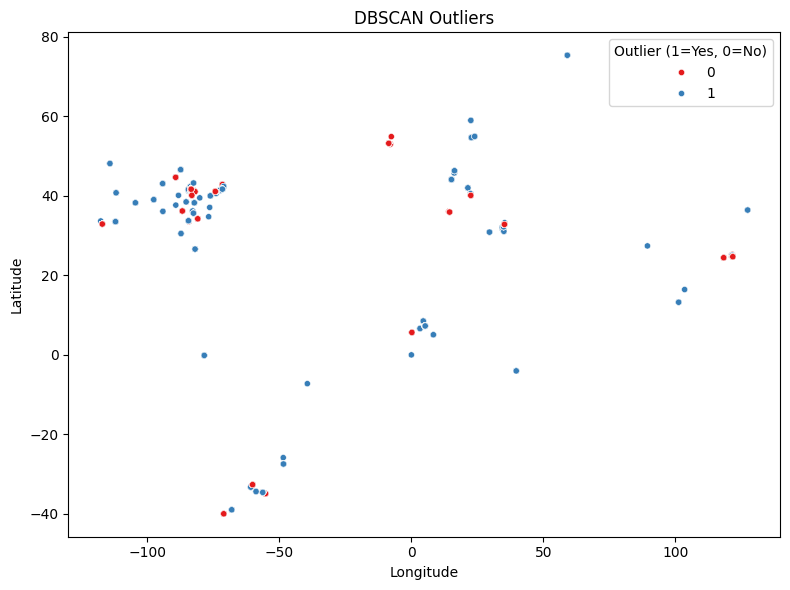

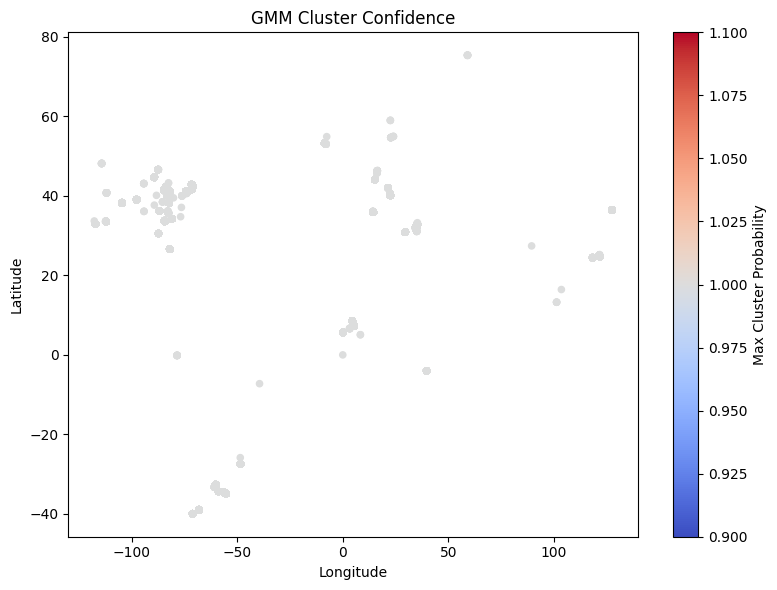

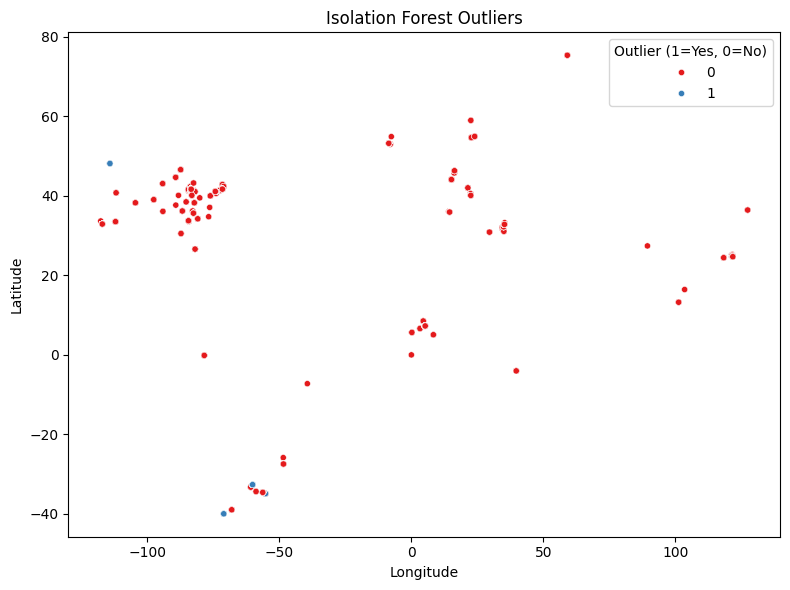

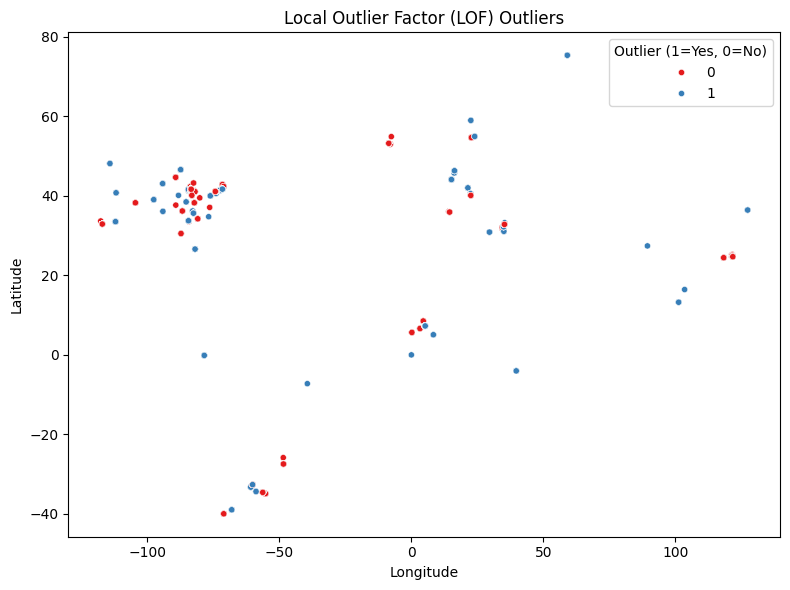

In [58]:

#DBSCAN

df_clean['dbscan_flag'] = dbscan_flag

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='site_longitude', y='site_latitude', hue='dbscan_flag', palette='Set1', s=20)
plt.title("DBSCAN Outliers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Outlier (1=Yes, 0=No)")
plt.tight_layout()
plt.show()

#GMM

df_clean['gmm_prob'] = gmm_probs

valid = df_clean['gmm_prob'].notna()

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df_clean.loc[valid, 'site_longitude'],
    df_clean.loc[valid, 'site_latitude'],
    c=df_clean.loc[valid, 'gmm_prob'],
    cmap='coolwarm',
    s=20
)
plt.title("GMM Cluster Confidence")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar(scatter)
cbar.set_label("Max Cluster Probability")
plt.tight_layout()
plt.show()

#Isolation Forest

df_clean['iso_flag'] = iso_flag

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='site_longitude', y='site_latitude', hue='iso_flag', palette='Set1', s=20)
plt.title("Isolation Forest Outliers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Outlier (1=Yes, 0=No)")
plt.tight_layout()
plt.show()

#Local outlier factor

df_clean['lof_flag'] = lof_flag

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_clean, x='site_longitude', y='site_latitude', hue='lof_flag', palette='Set1', s=20)
plt.title("Local Outlier Factor (LOF) Outliers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Outlier (1=Yes, 0=No)")
plt.tight_layout()
plt.show()

Collective Scoring

Based on the results of all 3 unsupervised clustering methods, I've assigned an anomaly score to each point. The higher the anomaly score, the more of an outlier the point is. This is how anomaly scores are assigned:

0.4 * (1 - GMM_PROBABILITY) +
0.3 * ISOLATION_FOREST_DECISION +
0.2 * DBSCAN_NOISE_FLAG +
0.1 * lof_flag

I've saved points with a relatively high anomaly score (>0.45) to collective_outliers.csv

In [59]:
anomaly_score = (
    0.4 * (1 - gmm_probs) +
    0.3 * MinMaxScaler().fit_transform(-iso.decision_function(X_scaled).reshape(-1, 1)).flatten() +
    0.2 * dbscan_flag +
    0.1 * lof_flag
)

final_flag = (anomaly_score > 0.45).astype(int)

result_df = df_clean.copy()
result_df['anomaly_score'] = anomaly_score
result_df['final_flag'] = final_flag
result_df['dbscan_flag'] = dbscan_flag
result_df['gmm_flag'] = gmm_flag
result_df['iso_flag'] = iso_flag
result_df['lof_flag'] = lof_flag

result_df.to_csv("collective_outliers.csv", index=False)

Interpretable Rule-Based Flagging

Some points just logically cannot exist (eg. latitude of 500 degrees). Other points are outliers which may be classified as noise. To flag these points, I set up a rule based flagging system which creates these new boolean columns:

Flagging based on things that cannot be logically possible, or are logical outliers

- lat_long_range: Latitude not in -90,90 and longitude not in -180,180

- high_elev_hot_temp: elevation >3000, and temp >35 C

- duplicated_coords: self explanatory

Flagging outliers

- zscore_outlier: If z-score of temp, or z-score of elevation > 3

- lof_flag: model which predicts outliers based on neighbors

- mahalanobis: similar to z-score, flags if distance > 3

Based on these flags, I create these additional columns:

- flag_sum: Count of active flags

- flag_final: True if flag_sum ≥ 3, else 0

I save all high-flag records (records where flag_final is True) to flagged_points.csv

I plotted the points, and colored them based on the amount of flags they have

I also plotted a Pearson correlation plots for flagged columns


Flagged 53167 rows out of 71165
Records with high flags: 822


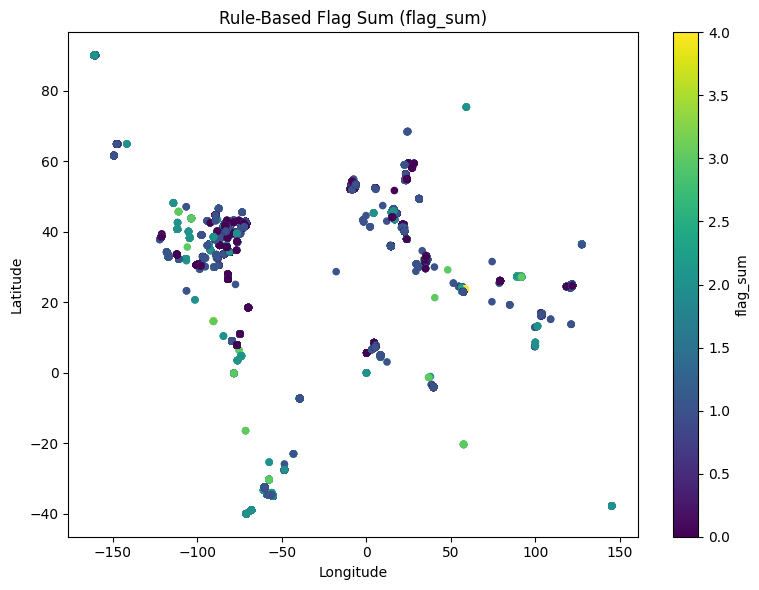

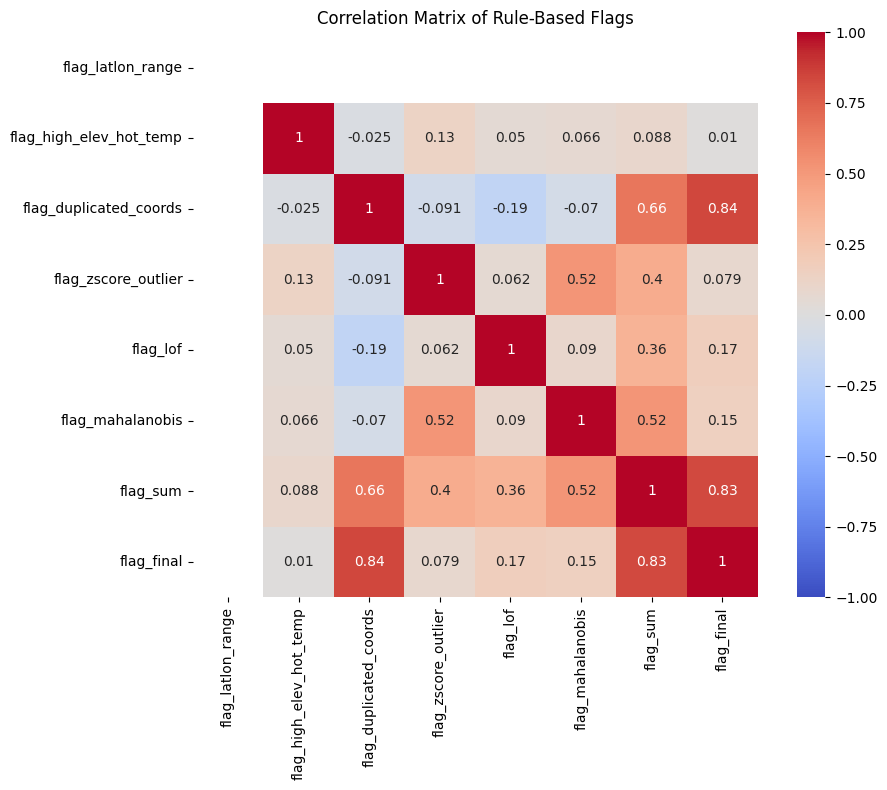

In [60]:


# Loading relevant numerical features
features = ['site_latitude', 'site_longitude', 'sample_surface_temperature_c', 'submission_elevation']
df_flagged = df[features].dropna().copy()

# Flagging logical anomalies and basic outliers
df_flagged['flag_latlon_range'] = ~df_flagged['site_latitude'].between(-90, 90) | ~df_flagged['site_longitude'].between(-180, 180)
df_flagged['flag_high_elev_hot_temp'] = (df_flagged['submission_elevation'] > 3000) & (df_flagged['sample_surface_temperature_c'] > 35)
df_flagged['flag_duplicated_coords'] = df_flagged.duplicated(subset=['site_latitude', 'site_longitude', 'sample_surface_temperature_c'], keep=False)

# Statistical outlier detection
df_flagged['z_temp'] = zscore(df_flagged['sample_surface_temperature_c'])
df_flagged['z_elev'] = zscore(df_flagged['submission_elevation'])
df_flagged['flag_zscore_outlier'] = (df_flagged['z_temp'].abs() > 3) | (df_flagged['z_elev'].abs() > 3)

# Density based outlier detection (Local Outlier Factor and Mahalanobis Distance)
lof = LocalOutlierFactor(n_neighbors=50)
df_flagged['flag_lof'] = lof.fit_predict(df_flagged[features]) == -1

X = df_flagged[features]
cov_matrix = np.cov(X.T)
inv_cov = np.linalg.inv(cov_matrix)
mean_vec = X.mean().values

df_flagged['mahalanobis'] = X.apply(lambda row: mahalanobis(row, mean_vec, inv_cov), axis=1)
df_flagged['flag_mahalanobis'] = df_flagged['mahalanobis'] > 3

# Combining flag logic
flag_cols = [col for col in df_flagged.columns if col.startswith("flag_")]
df_flagged['flag_sum'] = df_flagged[flag_cols].sum(axis=1)
df_flagged['flag_final'] = (df_flagged['flag_sum'] >= 3 | df_flagged['flag_latlon_range'])

# Inspect final flagged set
flagged_rows = df_flagged[df_flagged['flag_final'] == True]
print(f"Flagged {len(flagged_rows)} rows out of {len(df_flagged)}")
print(f"Records with high flags: {(df_flagged['flag_sum'] >= 3).sum()}")

# Exporting high-flagged records
flagged_rows.to_csv("flagged_points.csv", index=False)

# Plotting points based on number of flags
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    df_flagged['site_longitude'],
    df_flagged['site_latitude'],
    c=df_flagged['flag_sum'],
    cmap='viridis',
    s=20
)
plt.title("Rule-Based Flag Sum (flag_sum)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar(scatter)
cbar.set_label("flag_sum")
plt.tight_layout()
plt.show()

# Plotting Pearson Correlation between flags
flag_cols = [col for col in df_flagged.columns if col.startswith("flag_")]
flag_data = df_flagged[flag_cols].astype(int)
corr_matrix = flag_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix of Rule-Based Flags")
plt.tight_layout()
plt.show()




Merging Collective Scoring + Rule-Based Flags

To access the high anomaly scoring and high flagged records, I load collective_outliers.csv and flagged_points.csv

I merge on the four core features using inner join, which finds records shown in both sets.

I export the records, which according to my methods, contain the points which are greatest outliers and most likely to be noise

In [61]:
# Load both datasets
ensemble_df = pd.read_csv("collective_outliers.csv")
rules_df = pd.read_csv("flagged_points.csv")

# Filter rule-based only for strong flags
rules_filtered = rules_df[rules_df['flag_sum'] > 2].copy()

# Drop duplicates just in case
ensemble_df = ensemble_df.drop_duplicates()
rules_filtered = rules_filtered.drop_duplicates()

# Define join keys
join_keys = ['site_latitude', 'site_longitude', 'sample_surface_temperature_c', 'submission_elevation']

# Inner join to find overlap
merged = pd.merge(ensemble_df, rules_filtered, on=join_keys, how='inner')

# Report updated stats
print("🔍 Filtered Comparison (flag_sum > 2)")
print("-" * 45)
print(f"Total Ensemble Outliers: {len(ensemble_df)}")
print(f"Total Rule-Based Outliers (flag_sum > 2): {len(rules_filtered)}")
print(f"Overlapping Flagged Records: {len(merged)}")
print(f"% of Ensemble Outliers matched in Rule-based: {100 * len(merged) / len(ensemble_df):.2f}%")
print(f"% of Rule-based (flag_sum>2) matched in Ensemble: {100 * len(merged) / len(rules_filtered):.2f}%")

# Save overlapping records for inspection
merged.to_csv("greatest_outliers.csv", index=False)

🔍 Filtered Comparison (flag_sum > 2)
---------------------------------------------
Total Ensemble Outliers: 10704
Total Rule-Based Outliers (flag_sum > 2): 440
Overlapping Flagged Records: 80
% of Ensemble Outliers matched in Rule-based: 0.75%
% of Rule-based (flag_sum>2) matched in Ensemble: 18.18%


Output

- Flagged dataset (df_flagged)
- CSV with outlier points (greatest_outliers.csv)


In [62]:
#flagged dataset
df_flagged.head()

,site_latitude,site_longitude,sample_surface_temperature_c,submission_elevation,flag_latlon_range,flag_high_elev_hot_temp,flag_duplicated_coords,z_temp,z_elev,flag_zscore_outlier,flag_lof,mahalanobis,flag_mahalanobis,flag_sum,flag_final
27141,26.00290,79.16630,35.0,152.5,False,False,False,0.794205,-0.253952,False,False,1.514425,False,0,False
27152,26.00310,79.16630,30.0,151.6,False,False,False,0.416642,-0.256989,False,False,1.420829,False,0,False
27153,26.00285,79.16646,33.0,154.3,False,False,False,0.643180,-0.247877,False,False,1.465042,False,0,False
27154,26.00300,79.16660,27.0,153.8,False,False,True,0.190105,-0.249565,False,False,1.414017,False,1,True
27155,26.00300,79.16660,33.0,153.8,False,False,True,0.643180,-0.249565,False,False,1.465091,False,1,True


In [63]:
#contents of greatest_outliers.csv
merged.head()

,site_latitude,site_longitude,sample_surface_temperature_c,submission_elevation,protocol_id,instrument_type,usertype,dbscan_flag,gmm_prob,iso_flag,...,flag_high_elev_hot_temp,flag_duplicated_coords,z_temp,z_elev,flag_zscore_outlier,flag_lof,mahalanobis,flag_mahalanobis,flag_sum,flag_final
0,40.7505,-111.8634,8.5,1320.5,8,Etekcity 749,11,1,1.0,0,...,False,True,-1.206875,3.687897,True,False,3.907630,True,3,True
1,40.7505,-111.8634,10.1,1320.5,8,Etekcity 749,11,1,1.0,0,...,False,True,-1.086055,3.687897,True,False,3.879116,True,3,True
2,40.7505,-111.8634,-2.2,1320.5,8,Etekcity 749,11,1,1.0,0,...,False,True,-2.014858,3.687897,True,True,4.190142,True,4,True
3,40.7505,-111.8634,-2.6,1320.5,8,Etekcity 749,11,1,1.0,0,...,False,False,-2.045063,3.687897,True,True,4.203558,True,3,True
4,40.7505,-111.8634,-2.4,1320.5,8,Etekcity 749,11,1,1.0,0,...,False,False,-2.029961,3.687897,True,True,4.196827,True,3,True
